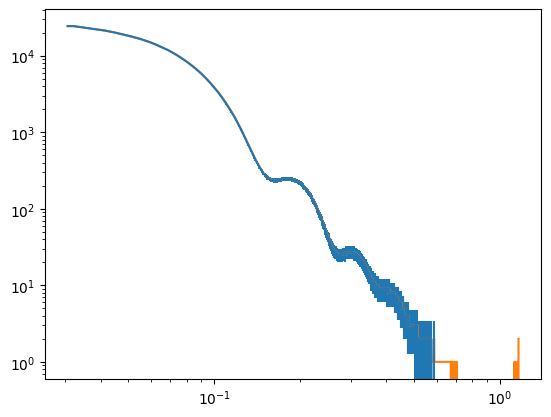

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# This first cell evaluates whether we can re-generate events from the histogram reliably.
# It is not used, you can skip it to the next bit which is more interseting...

# Bimodal gold contains 30 nm and 60 nm particles (300, 600 Å)
bmgold = np.loadtxt('data/roundrobin/dataset_1.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]

#mask = xdata < 1.0

#xdata = xdata[mask]
#ydata = ydata[mask]
#edata = edata[mask]

def rescale(yvals, evals):
    # Rescales yvals and errors data so that the error bars correctly match integer 
    # counts listed in yvals
    
    ymin = np.amin(yvals)
    ysum = np.sum(yvals)
    esum = np.sum(evals)
    rt = np.sqrt(ysum)
    
    factr = esum / rt
    factr = factr ** 2.0
    
    yvals = yvals * factr
    #esum = esum * factr
    
    #yvals = np.round(yvals).astype(int)
    
    return (yvals) 
    
def resample(xvals, yvals):
    # Resamples a histogram

    xpt = xvals[0]
    count = yvals[0]
    events = np.full((count), xpt)
    
    for bin in range(1, xvals.size, 1):
        xpt = xvals[bin]
        count = yvals[bin]
        
        if count > 1:
            evs = np.full((count), xpt)
            events = np.concatenate((events, evs))
    np.random.shuffle(events)
    return events


#ydata = rescale(ydata, edata)
ydata = ydata.astype(int)
events = resample(xdata, ydata)

nbins = xdata.size

lw = np.amin(events)
hi = np.amax(events)

#print(lw, hi)

slic = (hi-lw)/(nbins+1)

hbins = np.arange(lw, hi, slic)

hst = np.histogram(events, bins=hbins)
yhst = hst[0]
err = np.sqrt(yhst)
xhst = np.delete(hbins,-1)

#print(yhst)
#print(ydata)
fig,ax=plt.subplots()
ax.errorbar(xhst, yhst, err)
ax.plot(xdata, ydata)
ax.set_xscale('log')
ax.set_yscale('log')


array([21.])

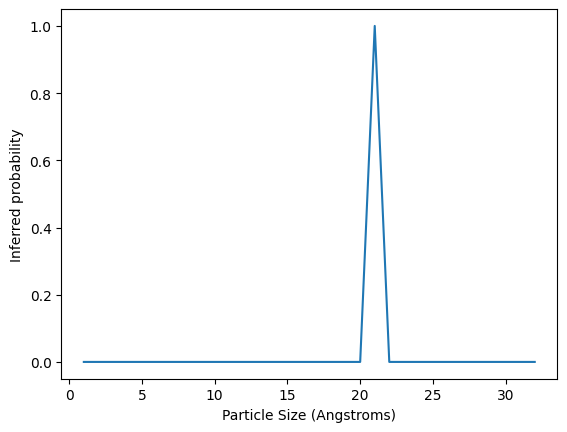

In [48]:
# Bayesian inference.  THIS WILL FAIL because we know we have a multi-modal data set 

import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

# Bimodal gold contains 30 nm and 60 nm particles (300, 600 Å)
bmgold = np.loadtxt('data/roundrobin/dataset_1.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]

#mask = xdata < 1.0

#xdata = xdata[mask]
#ydata = ydata[mask]
#edata = edata[mask]

model = bayesianInverse.bayesianSpheres()

model.datax = np.array(xdata)
model.datay = np.array(ydata)

model.infer(plotr=True)

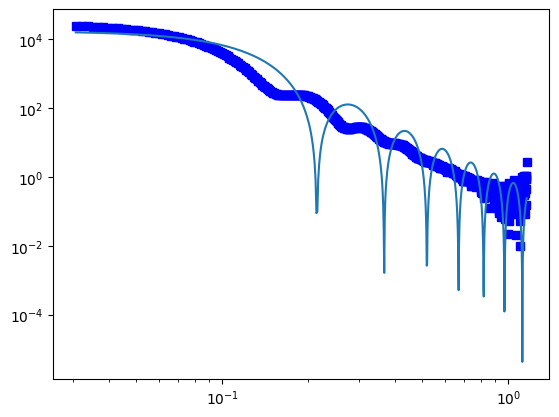

In [43]:
model.plotfit()

In [148]:
# Lucy Richardson
# This DOES work because it handles multi-modal probability distributions
import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

# Bimodal gold contains 30 nm and 60 nm particles (300, 600 Å)
bmgold = np.loadtxt('data/roundrobin/dataset_1.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]



model = bayesianInverse.bayesianSpheres()

model.datax = np.array(xdata)
model.datay = np.array(ydata)
model.sigmay= np.array(edata)

resto, errors = model.LR_deconv(niter=3000, calcErrors=True)

Lucy-Richardson fit failed to converge after 3000 iterations.
x2= 1.427547241606825


Text(0, 0.5, 'P(r)')

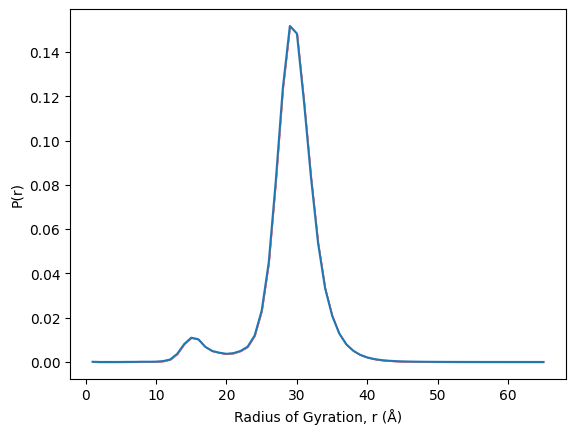

In [149]:
fity = model.getfity(resto, model.psf)

dats = np.sum(ydata)
fits = np.sum(fity)
fity = fity * dats/fits

psf, rvals = model.calc_psf()

top = resto+errors

bot = np.maximum(resto-errors, np.zeros_like(resto))

fig, ax = plt.subplots()
ax.plot(rvals, resto)

ax.fill_between(rvals, top, bot, color='red', alpha=0.5)

ax.set_xlabel("Radius of Gyration, r (Å)")
ax.set_ylabel("P(r)")

NOTE: This is actually in nm, not Å.

Text(0.7, 0.95, '$\\chi ^{2}$=1.4275')

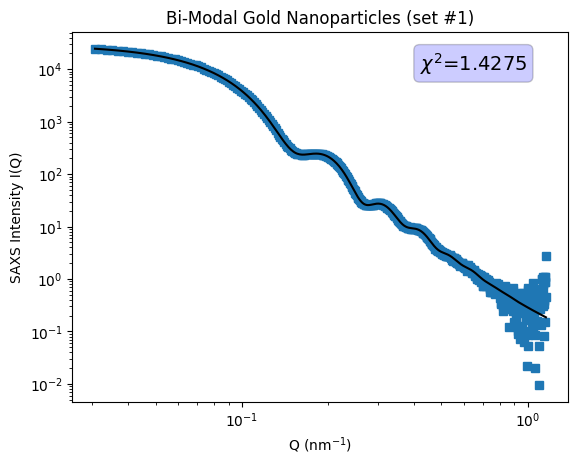

In [150]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 's')
ax.plot(xdata, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Q (nm$^{-1}$)")
ax.set_ylabel("SAXS Intensity I(Q)")
ax.set_title('Bi-Modal Gold Nanoparticles (set #1)')

chisq = model.x2(ydata, fity, edata)

insetstr = ''.join((r'$\chi ^{2}$=%.4f' % (chisq)))#/ydata.size)))
decs = dict(boxstyle='round', facecolor='blue', alpha=0.2)
ax.text(0.7, 0.95, insetstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=decs)

# Try playing with inverse model binning, maybe it's too coarse, and therefore cannot get a good X2!


In [151]:
# Lucy Richardson
# Data Set #2
import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

# Bimodal gold contains 30 nm and 60 nm particles (300, 600 Å)
bmgold = np.loadtxt('data/roundrobin/dataset_2.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]



model = bayesianInverse.bayesianSpheres()

model.datax = np.array(xdata)
model.datay = np.array(ydata)
model.sigmay= np.array(edata)

resto, errors = model.LR_deconv(niter=3000, calcErrors=True)

Lucy-Richardson fit failed to converge after 3000 iterations.
x2= 71.97964519830245


Text(0, 0.5, 'P(r)')

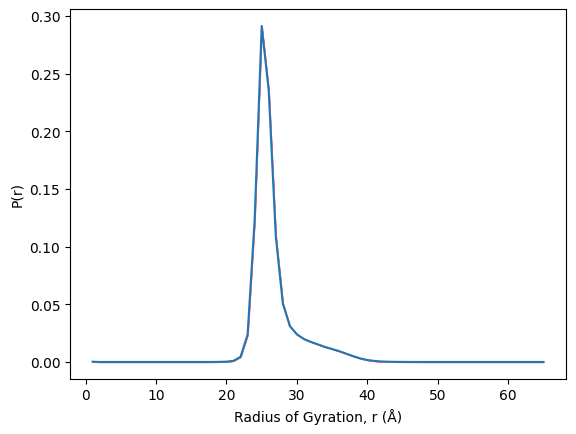

In [152]:
fity = model.getfity(resto, model.psf)

dats = np.sum(ydata)
fits = np.sum(fity)
fity = fity * dats/fits

psf, rvals = model.calc_psf()

top = resto+errors

bot = np.maximum(resto-errors, np.zeros_like(resto))

fig, ax = plt.subplots()
ax.plot(rvals, resto)

ax.fill_between(rvals, top, bot, color='red', alpha=0.5)

ax.set_xlabel("Radius of Gyration, r (Å)")
ax.set_ylabel("P(r)")

Text(0.7, 0.95, '$\\chi ^{2}$=71.9796')

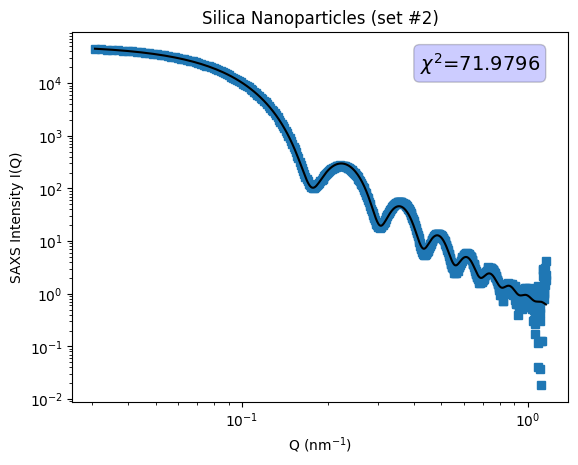

In [153]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 's')
ax.plot(xdata, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Q (nm$^{-1}$)")
ax.set_ylabel("SAXS Intensity I(Q)")
ax.set_title('Silica Nanoparticles (set #2)')

chisq = model.x2(ydata, fity, edata)

insetstr = ''.join((r'$\chi ^{2}$=%.4f' % (chisq)))#/ydata.size)))
decs = dict(boxstyle='round', facecolor='blue', alpha=0.2)
ax.text(0.7, 0.95, insetstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=decs)

In [154]:
# Lucy Richardson
# Data Set #3
import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

# Bimodal gold contains 30 nm and 60 nm particles (300, 600 Å)
bmgold = np.loadtxt('data/roundrobin/dataset_3.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]

mask = xdata < 1.0

xdata = xdata[mask]
ydata = ydata[mask]
edata = edata[mask]


model = bayesianInverse.bayesianSpheres()

model.datax = np.array(xdata)
model.datay = np.array(ydata)
model.sigmay= np.array(edata)

resto, errors = model.LR_deconv(niter=3000, calcErrors=True)

Lucy-Richardson fit failed to converge after 3000 iterations.
x2= 581.2546920948788


Text(0, 0.5, 'P(r)')

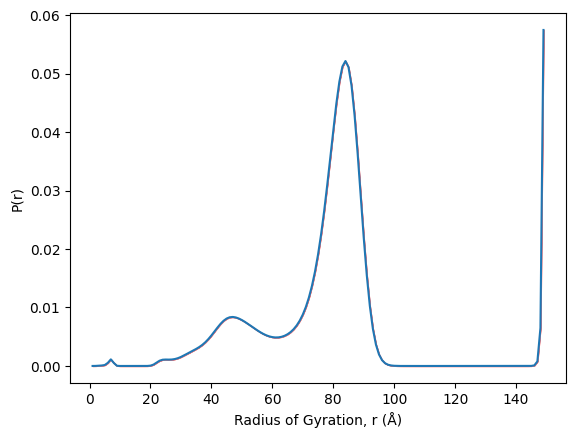

In [155]:
fity = model.getfity(resto, model.psf)

dats = np.sum(ydata)
fits = np.sum(fity)
fity = fity * dats/fits

psf, rvals = model.calc_psf()

top = resto+errors

bot = np.maximum(resto-errors, np.zeros_like(resto))

fig, ax = plt.subplots()
ax.plot(rvals, resto)

ax.fill_between(rvals, top, bot, color='red', alpha=0.5)

ax.set_xlabel("Radius of Gyration, r (Å)")
ax.set_ylabel("P(r)")

Text(0.7, 0.95, '$\\chi ^{2}$=581.2547')

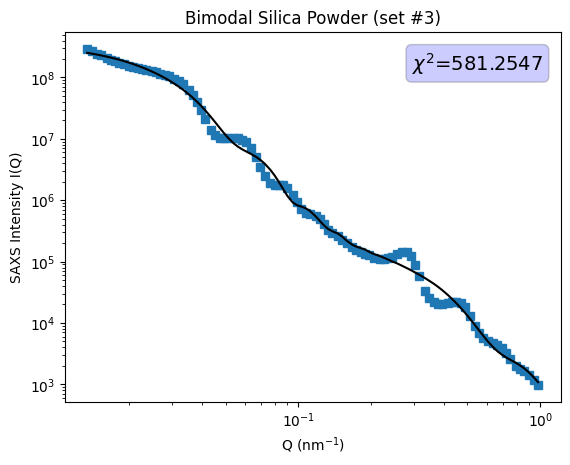

In [156]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 's')
ax.plot(xdata, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Q (nm$^{-1}$)")
ax.set_ylabel("SAXS Intensity I(Q)")
ax.set_title('Bimodal Silica Powder (set #3)')

chisq = model.x2(ydata, fity, edata)

insetstr = ''.join((r'$\chi ^{2}$=%.4f' % (chisq)))#/ydata.size)))
decs = dict(boxstyle='round', facecolor='blue', alpha=0.2)
ax.text(0.7, 0.95, insetstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=decs)

In [169]:
# Lucy Richardson
# Data Set #3
import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

# Bimodal gold contains 30 nm and 60 nm particles (300, 600 Å)
bmgold = np.loadtxt('data/roundrobin/dataset_4.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]

mask = xdata < 10.0

xdata = xdata[mask]
ydata = ydata[mask]
edata = edata[mask]

model = bayesianInverse.bayesianSpheres()

model.datax = np.array(xdata)
model.datay = np.array(ydata)
model.sigmay= np.array(edata)

resto, errors = model.LR_deconv(niter=3000, calcErrors=True)

Lucy-Richardson fit failed to converge after 3000 iterations.
x2= 60.79446026960795


Text(0, 0.5, 'P(r)')

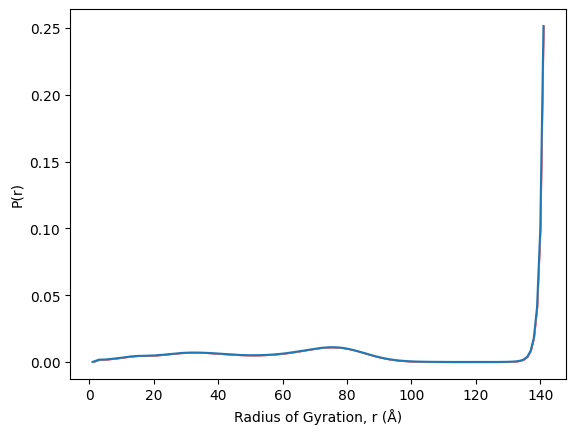

In [170]:
fity = model.getfity(resto, model.psf)

dats = np.sum(ydata)
fits = np.sum(fity)
fity = fity * dats/fits

psf, rvals = model.calc_psf()

top = resto+errors

bot = np.maximum(resto-errors, np.zeros_like(resto))

fig, ax = plt.subplots()
ax.plot(rvals, resto)

ax.fill_between(rvals, top, bot, color='red', alpha=0.5)

ax.set_xlabel("Radius of Gyration, r (Å)")
ax.set_ylabel("P(r)")

Text(0.7, 0.95, '$\\chi ^{2}$=60.7945')

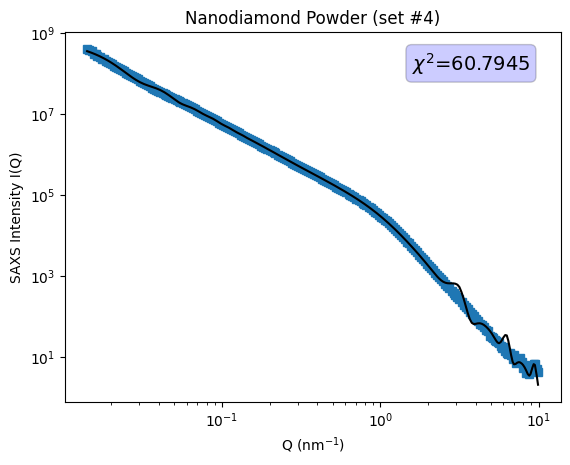

In [171]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 's')
ax.plot(xdata, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Q (nm$^{-1}$)")
ax.set_ylabel("SAXS Intensity I(Q)")
ax.set_title('Nanodiamond Powder (set #4)')

chisq = model.x2(ydata, fity, edata)

insetstr = ''.join((r'$\chi ^{2}$=%.4f' % (chisq)))#/ydata.size)))
decs = dict(boxstyle='round', facecolor='blue', alpha=0.2)
ax.text(0.7, 0.95, insetstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=decs)